In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch, cv2

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
#added by AspiringGuru. 
import urllib.request 
import shutil 
import os.path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [7]:
PATH = "data/dogscats/"
sz=224

In [8]:
torch.cuda.is_available()

True

In [9]:
os.getcwd()

'/home/ec2-user/fastai/courses/dl1'

In [10]:
!tree -d data/dogscats/ -I tmp

data/dogscats/
├── models
├── sample
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── valid
│       ├── cats
│       └── dogs
├── test
├── test1
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

16 directories


In [11]:
%%time
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.052421   0.027046   0.991699  
    1      0.04191    0.02614    0.990723                     

CPU times: user 16.8 s, sys: 12.5 s, total: 29.4 s
Wall time: 16.7 s


In [37]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aug_dl',
 'bs',
 'c',
 'classes',
 'fix_dl',
 'from_arrays',
 'from_csv',
 'from_dls',
 'from_names_and_array',
 'from_paths',
 'get_dl',
 'get_ds',
 'is_multi',
 'is_reg',
 'num_workers',
 'path',
 'resize',
 'resized',
 'sz',
 'test_aug_dl',
 'test_dl',
 'test_ds',
 'trn_dl',
 'trn_ds',
 'trn_y',
 'val_dl',
 'val_ds',
 'val_y']

In [50]:
print ("validation:", type(data.val_ds.y), data.val_ds.y.shape)
print ("training:", type(data.trn_ds.y), data.trn_ds.y.shape)
print ("data.test_dl:", dir(data.test_dl))
print ("data.test_aug_dl:", dir(data.test_aug_dl))

validation: <class 'numpy.ndarray'> (2000,)
training: <class 'numpy.ndarray'> (23000,)
data.test_dl: ['__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
data.test_aug_dl: ['__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [12]:
print ("classes:", data.classes)

classes: ['cats', 'dogs']


In [13]:
%%time
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
print ("log_preds.shape:", log_preds.shape)

log_preds.shape: (2000, 2)
CPU times: user 340 ms, sys: 492 ms, total: 832 ms
Wall time: 390 ms


In [14]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [15]:
print("preds:", type(preds), preds.shape, preds[0:5], np.unique(preds))
print("probs:", type(probs), probs.shape, probs[0:5])

preds: <class 'numpy.ndarray'> (2000,) [0 0 0 0 0] [0 1]
probs: <class 'numpy.ndarray'> (2000,) [0.00001 0.00004 0.00007 0.      0.00113]


In [16]:
acc = accuracy_score(data.val_ds.y, preds)
print ("accuracy for simplest model on validation dataset : ", acc)
print (confusion_matrix(data.val_ds.y, preds))

accuracy for simplest model on validation dataset :  0.9905
[[989  11]
 [  8 992]]


In [17]:
%%time
learn = ConvLearner.pretrained(arch, data, precompute=True)
print (type(learn))

<class 'fastai.conv_learner.ConvLearner'>
CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 2 s


In [18]:
%%time
lrf=learn.lr_find()
print (type(lrf))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 292/360 [00:05<00:01, 56.59it/s, loss=0.438]
<class 'NoneType'>                                           
CPU times: user 5.2 s, sys: 4.96 s, total: 10.2 s
Wall time: 5.19 s


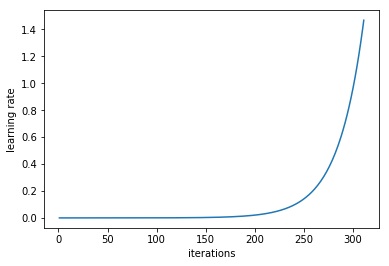

In [19]:
learn.sched.plot_lr()

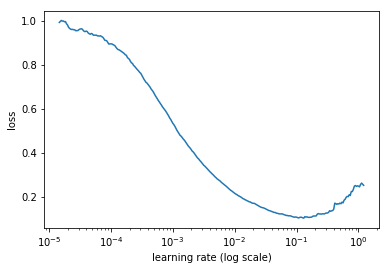

In [20]:
learn.sched.plot()

In [21]:
#data augmentation, 
#https://github.com/fastai/fastai/blob/master/fastai/transforms.py
#def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
#                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
#aug_tfms can be transforms_basic, transforms_side_on or transforms_top_down  (refer transforms.py)


tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
print (type(tfms), len(tfms), type(tfms[0]), type(tfms[1]))

<class 'tuple'> 2 <class 'fastai.transforms.Transforms'> <class 'fastai.transforms.Transforms'>


In [22]:
dir(tfms[0])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'denorm',
 'norm',
 'sz',
 'sz_y',
 'tfms']

In [23]:
%%time
#data augmentation, 
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 2.01 s


In [24]:
%%time
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.044399   0.025753   0.989258  

CPU times: user 6.21 s, sys: 6.13 s, total: 12.3 s
Wall time: 6.29 s


[0.025753306, 0.9892578125]

In [25]:
learn.precompute=False

In [26]:
%%time
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045941   0.024618   0.991699  
    1      0.041476   0.023828   0.991211                     
    2      0.040167   0.022932   0.991699                     

CPU times: user 16min 21s, sys: 2min 49s, total: 19min 11s
Wall time: 7min 22s


[0.022931708, 0.99169921875]

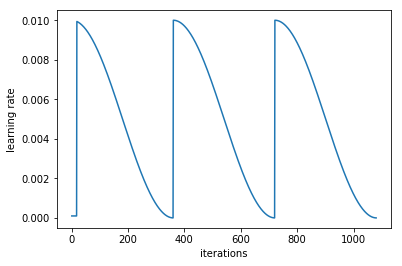

In [27]:
learn.sched.plot_lr()

In [28]:
%%time
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
acc = accuracy_score(data.val_ds.y, preds)
print ("accuracy for simplest model on validation dataset : ", acc)
print (confusion_matrix(data.val_ds.y, preds))

accuracy for simplest model on validation dataset :  0.9915
[[991   9]
 [  8 992]]
CPU times: user 20.2 s, sys: 4.09 s, total: 24.3 s
Wall time: 10.5 s


In [29]:
#final layer has been trained above, now fine-tune the other layers. unfreeze the remaining layers
learn.unfreeze()

In [30]:
#set differential learning rates, first few layers at 1e-4, middle layers at 1e-3, FC layers at 1e-2 
lr=np.array([1e-4,1e-3,1e-2])

In [31]:
%%time
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.048019   0.027092   0.989258  
    1      0.048218   0.025131   0.989258                     
    2      0.030613   0.022867   0.990723                     
    3      0.032487   0.023076   0.990723                     
    4      0.022881   0.021288   0.992188                     
    5      0.022248   0.020594   0.993164                     
    6      0.018849   0.020768   0.992676                     

CPU times: user 59min 42s, sys: 10min, total: 1h 9min 42s
Wall time: 41min 24s


[0.020767631, 0.99267578125]

#markup cell - results
epoch      trn_loss   val_loss   accuracy                     
    0      0.048019   0.027092   0.989258  
    1      0.048218   0.025131   0.989258                     
    2      0.030613   0.022867   0.990723                
    3      0.032487   0.023076   0.990723                     
    4      0.022881   0.021288   0.992188                     
    5      0.022248   0.020594   0.993164         

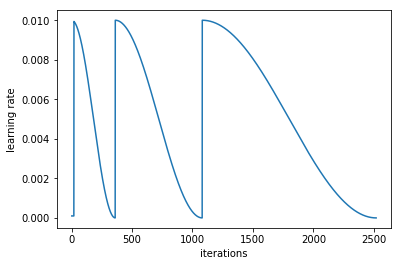

In [32]:
learn.sched.plot_lr()

In [33]:
%%time
print ("start")
log_preds,y = learn.TTA()
print ("log_preds:", type(log_preds), log_preds.shape)
print ("y:", type(y))
probs = np.mean(np.exp(log_preds),0)
print ("probs:", type(probs), probs.shape)

start
log_preds: <class 'numpy.ndarray'> (5, 2000, 2)
y: <class 'numpy.ndarray'>
probs: <class 'numpy.ndarray'>
CPU times: user 2min 1s, sys: 21.1 s, total: 2min 23s
Wall time: 53.7 s


In [34]:
accuracy_np(probs, y)

0.994

In [ ]:
#todo: average predictions, find argmax, create predicted label. then calc accuracy and confusion matrix.

In [36]:
print ("log_preds:", type(log_preds), log_preds.shape, log_preds.shape)
print ("y:", type(y), y.shape)
print ("probs:", type(probs), probs.shape)

log_preds: <class 'numpy.ndarray'> (5, 2000, 2) (5, 2000, 2)
y: <class 'numpy.ndarray'> (2000,)
probs: <class 'numpy.ndarray'> (5, 2)


In [62]:
temp = np.exp(log_preds)
print ("temp:", type(temp), temp.shape)
temp[:, 0, :]

temp: <class 'numpy.ndarray'> (5, 2000, 2)
unique: [0. 0. 0. ... 1. 1. 1.] 12908 6.151521e-05


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [54]:
print ()
print (np.unique(data.val_ds.y))
print (np.unique(y))

[0 1]
[0 1]


In [55]:
acc = accuracy_score(data.val_ds.y, y)
print ("accuracy for simplest model on validation dataset : ", acc)
print (confusion_matrix(data.val_ds.y, y))

accuracy for simplest model on validation dataset :  1.0
[[1000    0]
 [   0 1000]]
